# Noise correction between events
Using the calibration baseflow levels al reference, and find a scaling factor for the other events

In [1]:
import os
import re
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import soundfile as sf
from scipy.signal import hilbert
from scipy import stats

# function definition
def gain_compensation(data, gain):
    linear_gain = 10 ** (gain / 20)
    calibrated_data = data / linear_gain
    return calibrated_data

def field_noise(files_or_folder, channel, gain_db):
    """
    files_or_folder : str or list (path to the folder containing .flac recordings or a list of file paths)
    channel : str (Channel to use: 'left' or 'right')
    gain_db : float (Gain value (in dB) used in the field for the selected channel)
    -------
    Returns a DataFrame with columns ['filename', 'rms', 'rms_dB', 'date_str'].
    """
    results = []

    # determine if input is a folder or list of files
    if isinstance(files_or_folder, str):
        # folder path
        files = [os.path.join(files_or_folder, f) for f in os.listdir(files_or_folder) if f.endswith(".flac")]
    elif isinstance(files_or_folder, list):
        # list of file paths
        files = files_or_folder
    else:
        raise ValueError("files_or_folder must be a folder path or a list of file paths.")

    for filepath in files:
        filename = os.path.basename(filepath)
        data, samplerate = sf.read(filepath)

            # select the channel from input
        if data.ndim == 2:
            if channel.lower() == "left":
                data = data[:, 0]
            elif channel.lower() == "right":
                data = data[:, 1]
            else:
                raise ValueError("must be 'left' or 'right'.")

        # apply gain compensation
        data = gain_compensation(data, gain_db)

        # compute RMS amplitude
        rms = np.sqrt(np.mean(data ** 2))
        maa = np.mean(np.abs(data)) # mean absolute amplitude 
        peak = np.max(np.abs(data)) # peak amplitude

        envelope = np.abs(hilbert(data))
        mean_envelope = np.mean(envelope)
        std_envelope = np.std(envelope)
        p90_envelope = np.percentile(envelope, 90)

        # extract datetime info from filename (e.g., raspberrypi_072321-081600)
        try:
            date_str = filename.split("_")[1].split(".")[0]
        except:
            date_str = filename

        results.append({
            "filename": filename,
            "rms": rms,
            "maa": maa,
            "peak": peak,
            "mean_envelope": mean_envelope,
            "std_envelope": std_envelope,
            "p90_envelope": p90_envelope,
            "date_str": date_str
        })
    noise_df = pd.DataFrame(results)
    return noise_df

def calibration_noise(data, samplerate, channel, gain_db, segment_duration_sec=60):
    """
    data : 2D array (audio data)
    samplerate : int (sampling rate in Hz)
    channel : str (Channel to use: 'left' or 'right')
    gain_db : float (Gain value (in dB) used in the field for the selected channel)
    segment_duration_sec : int (length of each segment in seconds)
    -------
    Returns a DataFRame with columns ['minute', 'rms', 'rms_dB' and 'recording'].
    """
    # select the channel from input
    if data.ndim == 2:
        if channel.lower() == "left":
            data = data[:, 0]
        elif channel.lower() == "right":
            data = data[:, 1]
        else:
            raise ValueError("must be 'left' or 'right'.")
    # apply gain compensation
    data = gain_compensation(data, gain_db)
    
    samples_per_segment = samplerate * segment_duration_sec
    total_segments = int(len(data) / samples_per_segment)
    
    results = []
    
    for i in range(total_segments):
        start = int(i * samples_per_segment)
        end = int(start + samples_per_segment)
        segment = data[start:end]

        rms = np.sqrt(np.mean(segment**2)) # root mean square amplitude
        maa = np.mean(np.abs(segment)) # mean absolute amplitude 
        peak = np.max(np.abs(segment)) # peak amplitude

        envelope = np.abs(hilbert(segment))
        mean_envelope = np.mean(envelope)
        std_envelope = np.std(envelope)
        p90_envelope = np.percentile(envelope, 90)

        results.append({
            "minute": i,             # minute index (0 to 19)
            "rms": rms,
            "maa": maa,
            "peak": peak,
            "mean_envelope": mean_envelope,
            "std_envelope": std_envelope,
            "p90_envelope": p90_envelope,
        })
    return pd.DataFrame(results)

### Import discharge data

In [2]:
# import shear stress data, making first column date_time and the index
tau_2022 = pd.read_csv('../mobile_shear_stress_2022.csv', index_col=0, parse_dates=True)
tau_2023 = pd.read_csv('../mobile_shear_stress_2023.csv', index_col=0, parse_dates=True)
tau_calibration = pd.read_csv('../../Shear Stress/stress_partitioning/flood_experiments_2023/calibration_experiments_shear_stress.csv', index_col=0, parse_dates=True)
# give the second column a name
tau_2022.columns = ['tau']
tau_2023.columns = ['tau']
tau_calibration.rename(columns={'shear_stress': 'tau'}, inplace=True)

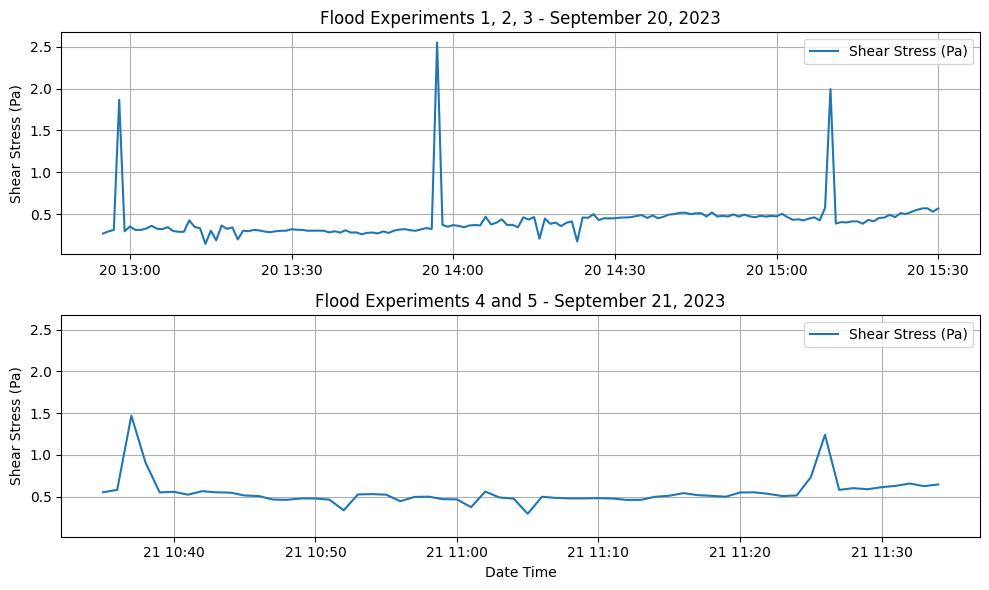

In [3]:
# plot shear stress during flood events - separated by days
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=False, sharey=True)

# Day 1: 2023-09-20
day1_data = tau_calibration.loc['2023-09-20 12:55:00':'2023-09-20 15:30:00']
ax1.plot(day1_data.index, day1_data['tau'], label='Shear Stress (Pa)')
ax1.set_ylabel('Shear Stress (Pa)')
ax1.set_title('Flood Experiments 1, 2, 3 - September 20, 2023')
ax1.legend()
ax1.grid(True)

# Day 2: 2023-09-21
day2_data = tau_calibration.loc['2023-09-21 10:35:00':'2023-09-21 11:34:00']
ax2.plot(day2_data.index, day2_data['tau'], label='Shear Stress (Pa)')
ax2.set_xlabel('Date Time')
ax2.set_ylabel('Shear Stress (Pa)')
ax2.set_title('Flood Experiments 4 and 5 - September 21, 2023')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [4]:
# periods of baseflow: 
experiment_baseflow = pd.concat([
    tau_calibration.loc['2023-09-20 13:00:00':'2023-09-20 13:10:00'],
    tau_calibration.loc['2023-09-20 13:30:00':'2023-09-20 13:45:00'],
    tau_calibration.loc['2023-09-20 14:30:00':'2023-09-20 15:00:00'],
    tau_calibration.loc['2023-09-20 15:15:00':'2023-09-20 15:30:00'],  
    tau_calibration.loc['2023-09-21 10:40:00':'2023-09-21 10:50:00'],
    tau_calibration.loc['2023-09-21 11:10:00':'2023-09-21 11:20:00'],
])['tau']

### Import calibration recordings

In [5]:
# all sample rates for these recordings are 44100 Hz and they are all 20 minutes
flood_files = {
#"flood1": "../Calibration/EXP-09-20-23-FLOW1//audio/Nicole_091823-000100.flac",
#"flood11": "../Calibration/EXP-09-20-23-FLOW1//audio/Nicole_091823-002300.flac",
"flood2": "../Calibration/EXP-09-20-23-FLOW2//audio/Nicole_091823-000100.flac",
"flood3": "../Calibration/EXP-09-20-23-FLOW3//audio/Nicole_091823-000100.flac",
"flood4": "../Calibration/EXP-09-21-23-FLOW4//audio/Nicole_091823-000100.flac",
"flood44": "../Calibration/EXP-09-21-23-FLOW4//audio/Nicole_091823-002300.flac",
"flood5": "../Calibration/EXP-09-21-23-FLOW5//audio/Nicole_091823-000100.flac",
"flood55": "../Calibration/EXP-09-21-23-FLOW5//audio/Nicole_091823-002300.flac"
}

flood_rec_start_times = {
    #"flood1": "2023-09-20 12:56:00",
    #"flood11": "2023-09-20 13:16:00",  
    "flood2": "2023-09-20 13:54:00",   
    "flood3": "2023-09-20 15:05:00",   
    "flood4": "2023-09-21 10:26:00",   
    "flood44": "2023-09-21 10:46:00",  
    "flood5": "2023-09-21 11:24:00",   
    "flood55": "2023-09-21 11:44:00"   
}

Calculate noise and store as a time series

In [6]:
flood_results = []

for label, path in flood_files.items():
    data, samplerate = sf.read(path)
    ts_df = calibration_noise(data, samplerate, gain_db=23,channel="left", segment_duration_sec=60)
    ts_df["recording"] = label
    flood_results.append(ts_df)

# combine all results into one DataFrame
calibration_df = pd.concat(flood_results, ignore_index=True)
print(calibration_df.head())

   minute       rms       maa      peak  mean_envelope  std_envelope  \
0       0  0.000021  0.000014  0.000538       0.000021      0.000021   
1       1  0.000032  0.000016  0.001363       0.000026      0.000037   
2       2  0.000021  0.000013  0.000529       0.000021      0.000020   
3       3  0.000359  0.000062  0.048073       0.000097      0.000498   
4       4  0.000028  0.000016  0.000873       0.000026      0.000030   

   p90_envelope recording  
0      0.000040    flood2  
1      0.000045    flood2  
2      0.000039    flood2  
3      0.000151    flood2  
4      0.000049    flood2  


In [7]:
# add datetime column to calibration_df
calibration_df['Date_Time'] = pd.NaT  # initialize with NaT (Not a Time)

for recording in calibration_df['recording'].unique():
    mask = calibration_df['recording'] == recording
    start_time = pd.to_datetime(flood_rec_start_times[recording])
    # create datetime series for this recording (minute 0, 1, 2, ... becomes actual timestamps)
    minutes_offset = calibration_df.loc[mask, 'minute']
    calibration_df.loc[mask, 'Date_Time'] = start_time + pd.to_timedelta(minutes_offset, unit='min')

# set datetime as index 
calibration_df.set_index('Date_Time', inplace=True)
print(calibration_df.head(10))

                     minute       rms       maa      peak  mean_envelope  \
Date_Time                                                                  
2023-09-20 13:54:00       0  0.000021  0.000014  0.000538       0.000021   
2023-09-20 13:55:00       1  0.000032  0.000016  0.001363       0.000026   
2023-09-20 13:56:00       2  0.000021  0.000013  0.000529       0.000021   
2023-09-20 13:57:00       3  0.000359  0.000062  0.048073       0.000097   
2023-09-20 13:58:00       4  0.000028  0.000016  0.000873       0.000026   
2023-09-20 13:59:00       5  0.000025  0.000015  0.000797       0.000024   
2023-09-20 14:00:00       6  0.000025  0.000014  0.000866       0.000023   
2023-09-20 14:01:00       7  0.000024  0.000015  0.000544       0.000024   
2023-09-20 14:02:00       8  0.000024  0.000015  0.000616       0.000023   
2023-09-20 14:03:00       9  0.000023  0.000014  0.000560       0.000022   

                     std_envelope  p90_envelope recording  
Date_Time                  

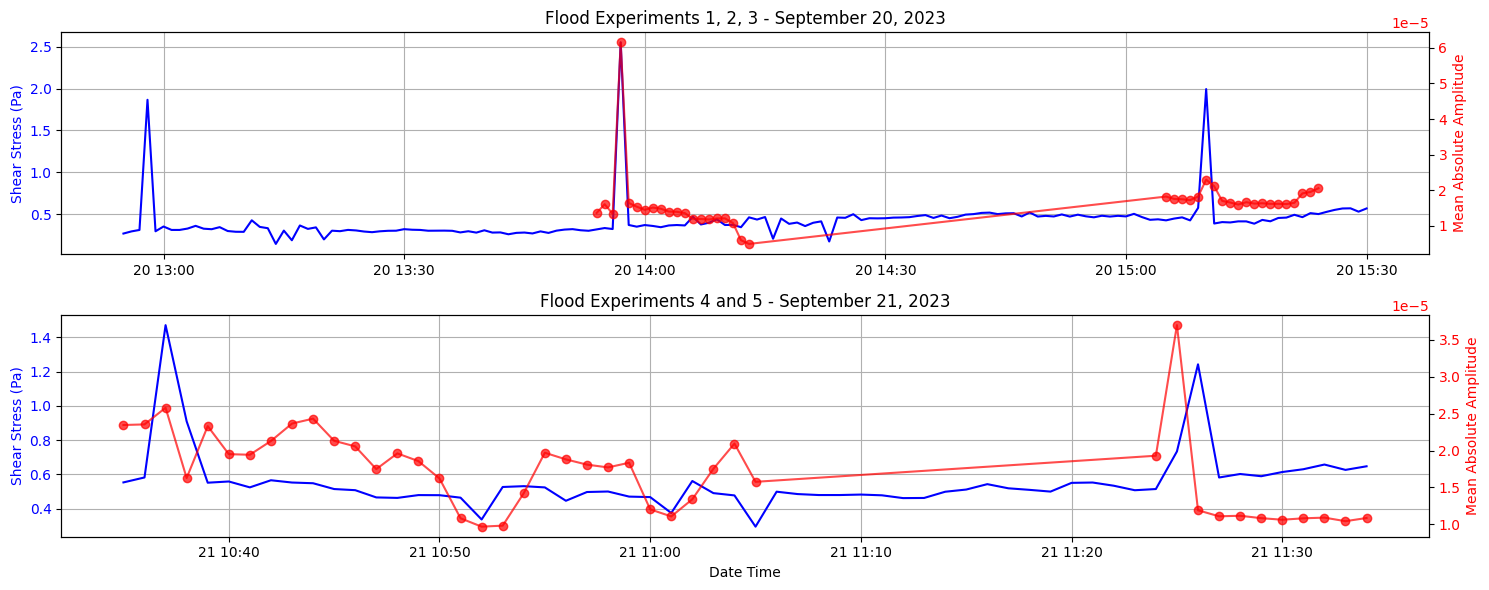

In [8]:
# plot shear stress during flood events - separated by days
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6), sharex=False)

# Day 1: 2023-09-20
day1_data = tau_calibration.loc['2023-09-20 12:55:00':'2023-09-20 15:30:00']
day1_rms = calibration_df.loc['2023-09-20 12:55:00':'2023-09-20 15:30:00']

ax1.plot(day1_data.index, day1_data['tau'], label='Shear Stress (Pa)', color='blue')
ax1.set_ylabel('Shear Stress (Pa)', color='blue')
ax1.set_title('Flood Experiments 1, 2, 3 - September 20, 2023')
ax1.grid(True)
ax1.tick_params(axis='y', labelcolor='blue')

# Create secondary y-axis for RMS
ax1_twin = ax1.twinx()
ax1_twin.plot(day1_rms.index, day1_rms['maa'], linestyle='-', marker='o', label='Mean Absolute Amplitude', color='red', alpha=0.7)
ax1_twin.set_ylabel('Mean Absolute Amplitude', color='red')
ax1_twin.tick_params(axis='y', labelcolor='red')

# Day 2: 2023-09-21
day2_data = tau_calibration.loc['2023-09-21 10:35:00':'2023-09-21 11:34:00']
day2_rms = calibration_df.loc['2023-09-21 10:35:00':'2023-09-21 11:34:00']

ax2.plot(day2_data.index, day2_data['tau'], label='Shear Stress (Pa)', color='blue')
ax2.set_xlabel('Date Time')
ax2.set_ylabel('Shear Stress (Pa)', color='blue')
ax2.set_title('Flood Experiments 4 and 5 - September 21, 2023')
ax2.grid(True)
ax2.tick_params(axis='y', labelcolor='blue')

# Create secondary y-axis for RMS
ax2_twin = ax2.twinx()
ax2_twin.plot(day2_rms.index, day2_rms['maa'], linestyle='-', marker='o', label='Mean Absolute Amplitude', color='red', alpha=0.7)
ax2_twin.set_ylabel('Mean Absolute Amplitude', color='red')
ax2_twin.tick_params(axis='y', labelcolor='red')

plt.tight_layout()
plt.show()

Merge shear stress data to it

In [9]:
# merge shear stress data with calibration_df on matching timestamps (only keep timestamps that exist in both datasets)
calibration_df = calibration_df.merge(tau_calibration['tau'], left_index=True, right_index=True, how='inner')  
print(calibration_df.head())
calibration_df.to_csv('calibration_experiments_shear_stress_and_rms.csv')

                     minute       rms       maa      peak  mean_envelope  \
2023-09-20 13:54:00       0  0.000021  0.000014  0.000538       0.000021   
2023-09-20 13:55:00       1  0.000032  0.000016  0.001363       0.000026   
2023-09-20 13:56:00       2  0.000021  0.000013  0.000529       0.000021   
2023-09-20 13:57:00       3  0.000359  0.000062  0.048073       0.000097   
2023-09-20 13:58:00       4  0.000028  0.000016  0.000873       0.000026   

                     std_envelope  p90_envelope recording       tau  
2023-09-20 13:54:00      0.000021      0.000040    flood2  0.315977  
2023-09-20 13:55:00      0.000037      0.000045    flood2  0.332253  
2023-09-20 13:56:00      0.000020      0.000039    flood2  0.320386  
2023-09-20 13:57:00      0.000498      0.000151    flood2  2.554105  
2023-09-20 13:58:00      0.000030      0.000049    flood2  0.369095  


Baseflow mask

In [10]:
# baseflow mask - keep only data that matches experiment_baseflow timestamps
baseflow_calibration = calibration_df[calibration_df.index.isin(experiment_baseflow.index)]
print(baseflow_calibration.head())

                     minute       rms       maa      peak  mean_envelope  \
2023-09-20 15:15:00      10  0.000026  0.000017  0.000648       0.000026   
2023-09-20 15:16:00      11  0.000025  0.000016  0.000542       0.000026   
2023-09-20 15:17:00      12  0.000026  0.000016  0.000825       0.000026   
2023-09-20 15:18:00      13  0.000026  0.000016  0.000553       0.000025   
2023-09-20 15:19:00      14  0.000025  0.000016  0.000784       0.000025   

                     std_envelope  p90_envelope recording       tau  
2023-09-20 15:15:00      0.000026      0.000050    flood3  0.411935  
2023-09-20 15:16:00      0.000025      0.000049    flood3  0.384467  
2023-09-20 15:17:00      0.000026      0.000049    flood3  0.429490  
2023-09-20 15:18:00      0.000026      0.000048    flood3  0.413191  
2023-09-20 15:19:00      0.000024      0.000049    flood3  0.452968  


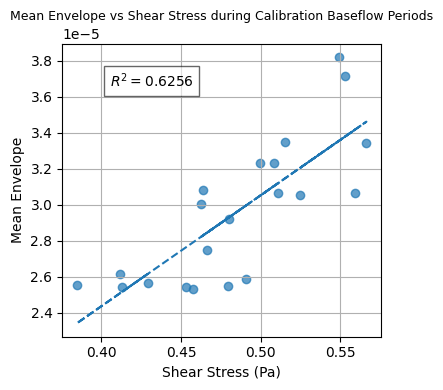

In [11]:
# scatter plot of mean envelope vs shear stress during baseflow periods
# perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(baseflow_calibration['tau'], baseflow_calibration['mean_envelope'])
r_squared = r_value**2
fit_line = slope * baseflow_calibration['tau'] + intercept

plt.figure(figsize=(4, 4))
plt.scatter(baseflow_calibration['tau'], baseflow_calibration['mean_envelope'], alpha=0.7)
plt.plot(baseflow_calibration['tau'], fit_line, linestyle='--')
plt.xlabel('Shear Stress (Pa)')
plt.ylabel('Mean Envelope')
plt.title('Mean Envelope vs Shear Stress during Calibration Baseflow Periods', fontsize=9)
plt.text(0.15, 0.85, f'$R^2 = {r_squared:.4f}$', transform=plt.gca().transAxes, 
        fontsize=10, bbox=dict(facecolor='white', alpha=0.6))
plt.grid(True)
plt.tight_layout()
plt.show()

del slope, intercept, r_value, p_value, std_err, r_squared, fit_line

### Find times whith same shear stresses

In [12]:
# apply baseflow mask to tau_calibration
baseflow_tau_calibration = tau_calibration[tau_calibration.index.isin(experiment_baseflow.index)]

# function to find matches between calibration and another dataset
def find_matching_stresses(df_cal, df_other, tolerance=0.001): # tolerance in Pa to make sure there is some similar range
    matches = []
    for ts_cal, stress in df_cal['tau'].items():
        # find rows where tau is within tolerance
        subset = df_other[np.isclose(df_other['tau'], stress, atol=tolerance)]
        
        if not subset.empty:
            # find the record closest in time
            time_diff = pd.Series(abs(subset.index - ts_cal), index=subset.index)
            best_ts = time_diff.idxmin()
            matches.append({
                'cal_timestamp': ts_cal,
                'cal_stress': stress,
                'match_timestamp': best_ts,
                'match_stress': df_other.loc[best_ts, 'tau'],
                'time_diff': time_diff.loc[best_ts]
            })
    return pd.DataFrame(matches)

In [13]:
matches_2022 = find_matching_stresses(baseflow_tau_calibration, tau_2022)
matches_2022.to_csv('matching_stresses_2022.csv')

In [14]:
matches_2023 = find_matching_stresses(baseflow_tau_calibration, tau_2023)
matches_2023.to_csv('matching_stresses_2023.csv')

###  Import data files with matching dates

In [15]:
def parse_timestamp_from_filename(filename):
    """
    Parse timestamp from filename format: raspberrypi_MMDDYY-HHMMSS.flac
    """
    match = re.search(r"(\d{6})-(\d{6})", filename)
    if match:
        date_str, time_str = match.groups()
        # convert to datetime (note: assumes 2000+ for the year)
        dt = datetime.strptime(date_str + time_str, "%m%d%y%H%M%S")
        return dt
    return None


def get_matching_soundfiles(base_folders, match_times, time_tolerance=60):
    """
    base_folders : list of folder paths
    match_times : iterable of datetime objects to match
    time_tolerance : seconds of tolerance between file timestamp and match time
    Returns a list of filepaths to process.
    """
    selected_files = []
    all_match_times = pd.to_datetime(match_times)

    for base_folder in base_folders:
        for filename in os.listdir(base_folder):
            if filename.endswith(".flac"):
                file_dt = parse_timestamp_from_filename(filename)
                if file_dt is not None:
                    # check if file is within tolerance of any match time
                    if any(abs((file_dt - mt).total_seconds()) <= time_tolerance for mt in all_match_times):
                        selected_files.append(os.path.join(base_folder, filename))
    return selected_files

In [16]:
base_folders = ["matching_shear_stress_recordings/2022", "matching_shear_stress_recordings/2023"]
matching_files_2022 = get_matching_soundfiles(base_folders, matches_2022['match_timestamp'])
matching_files_2023 = get_matching_soundfiles(base_folders, matches_2023['match_timestamp'])
print(f"Found {len(matching_files_2022)} relevant soundfiles for 2022")
print(f"Found {len(matching_files_2023)} relevant soundfiles for 2023")

Found 66 relevant soundfiles for 2022
Found 3 relevant soundfiles for 2023


In [17]:
match_baseflow_2022 = field_noise(matching_files_2022, channel="right", gain_db=30)
match_baseflow_2023 = field_noise(matching_files_2023, channel="left", gain_db=23)

In [18]:
match_baseflow_2022['Date_Time'] = pd.to_datetime(match_baseflow_2022['date_str'], format="%m%d%y-%H%M%S")
match_baseflow_2022 = match_baseflow_2022.set_index('Date_Time')
match_baseflow_2023['Date_Time'] = pd.to_datetime(match_baseflow_2023['date_str'], format="%m%d%y-%H%M%S")
match_baseflow_2023 = match_baseflow_2023.set_index('Date_Time')

In [19]:
match_baseflow_2022 = match_baseflow_2022.merge(tau_2022, left_index=True, right_index=True, how='left')
match_baseflow_2023 = match_baseflow_2023.merge(tau_2023, left_index=True, right_index=True, how='left')
match_baseflow_2022 = match_baseflow_2022.drop(columns=['filename'])
match_baseflow_2023 = match_baseflow_2023.drop(columns=['filename'])
print(match_baseflow_2022.head())

                          rms       maa      peak  mean_envelope  \
Date_Time                                                          
2022-03-27 07:00:00  0.000002  0.000001  0.000013       0.000002   
2022-03-31 10:45:00  0.000002  0.000002  0.000012       0.000002   
2022-04-02 10:00:00  0.000002  0.000002  0.000014       0.000003   
2022-04-02 10:45:00  0.000002  0.000002  0.000014       0.000003   
2022-04-02 11:15:00  0.000003  0.000002  0.000015       0.000003   

                     std_envelope  p90_envelope       date_str       tau  
Date_Time                                                                 
2022-03-27 07:00:00      0.000001      0.000004  032722-070000  0.257304  
2022-03-31 10:45:00      0.000001      0.000004  033122-104500  0.274622  
2022-04-02 10:00:00      0.000002      0.000005  040222-100000  0.317837  
2022-04-02 10:45:00      0.000002      0.000005  040222-104500  0.325164  
2022-04-02 11:15:00      0.000002      0.000005  040222-111500  0.327050 

In [20]:
for df in [matches_2022, matches_2023]:
    df['Calibration_Time'] = pd.to_datetime(df['cal_timestamp'], format="%m%d%y-%H%M%S")
    df.set_index('Calibration_Time', inplace=True)
    df.sort_index(inplace=True)
    df.drop(columns=['cal_timestamp'])

In [21]:
merged_2022 = matches_2022.merge(baseflow_calibration, left_index=True, right_index=True, how='left')
merged_2023 = matches_2023.merge(baseflow_calibration, left_index=True, right_index=True, how='left')

In [22]:
print(matches_2022.head())

                          cal_timestamp  cal_stress     match_timestamp  \
Calibration_Time                                                          
2023-09-20 13:00:00 2023-09-20 13:00:00    0.350536 2022-05-05 20:30:00   
2023-09-20 13:01:00 2023-09-20 13:01:00    0.309568 2022-05-06 03:30:00   
2023-09-20 13:02:00 2023-09-20 13:02:00    0.309532 2022-05-06 03:30:00   
2023-09-20 13:03:00 2023-09-20 13:03:00    0.326062 2022-04-02 11:15:00   
2023-09-20 13:04:00 2023-09-20 13:04:00    0.358518 2022-05-05 18:00:00   

                     match_stress         time_diff  
Calibration_Time                                     
2023-09-20 13:00:00      0.351042 502 days 16:30:00  
2023-09-20 13:01:00      0.309926 502 days 09:31:00  
2023-09-20 13:02:00      0.309926 502 days 09:32:00  
2023-09-20 13:03:00      0.327050 536 days 01:48:00  
2023-09-20 13:04:00      0.357879 502 days 19:04:00  


In [23]:
merged_2022.to_csv("matching_tau_results/matching_baseflow_calibration_2022.csv")
merged_2023.to_csv("matching_tau_results/matching_baseflow_calibration_2023.csv")
match_baseflow_2022.to_csv("matching_tau_results/matched_baseflow_2022.csv")
match_baseflow_2023.to_csv("matching_tau_results/matched_baseflow_2023.csv")